# Credit Card Fraud Detection

Il dataset contiene transazioni fatte tramite carta di credito nel settembre 2013 in Europa.
Questo dataset presenta transazioni avvenute in due giorni. Delle 284807 transazioni, 492 sono etichettate come frodi, le altre sono da ritenersi legittime. Il dataset è estremamente sbilanciato, con i casi positivi che rappresentano soltanto lo 0.172% di tutte le transazioni.

Nel dataset sono presenti soltanto variabili di input di tipo numerico, risultanti da una trasformazione Principal Component Analysis (PCA). Per ragioni di confidenzialità non sono disponibili né le features originali né informazioni sull'origine dei dati più dettagliate. Le uniche features non trasformate tramite PCA sono 'Tempo' e 'Ammontare'.
Il tempo misura i sencondi trascorsi tra ogni transazione e la prima transazione del dataset. La feature 'Ammontare' è l'ammontare della transazione.
Le transazioni etichettate con 1 sono frodi, quelle etichettate con 0 sono legittime.



## Setup dell'ambiente

In [1]:
! rm -Rf /content/creditfraud/
! which kaggle || pip install kaggle
! if ! [ -d ~/.kaggle ] ; then  mkdir ~/.kaggle  && touch ~/.kaggle/kaggle.json; echo "Creating kaggle directory"; fi

import json

token = {"username":"andreaaugello","key":"636f00800308e8447dea0ee8f2decb98"}

import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! if ! [ -f /content/creditfraud/creditcard.csv ] ; then chmod 600 /root/.kaggle/kaggle.json && kaggle datasets download -p /content/creditfraud/ -d mlg-ulb/creditcardfraud ; fi

os.chdir('/content/creditfraud')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

/usr/local/bin/kaggle
 89% 59.0M/66.0M [00:00<00:00, 156MB/s]
100% 66.0M/66.0M [00:00<00:00, 189MB/s]


In [2]:
!head -n 2 /content/creditfraud/creditcard.csv
!tail -n 2 /content/creditfraud/creditcard.csv

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,"0"
172788,-0.240440049680947,0.530482513118839,0.702510230095103,0.689799168040973,-0.377961134444982,0.62370772214768,-0.68617998628885,0.679145459790659,0.392086712465972,-0.399125651432835,-1.93384881505713,-0.962886142890271,-1.04208165591191,0.449624443166001,1.96256312066577,-0.60857

In [3]:
%%shell

apt-get install openjdk-8-jdk-headless -qq 
if ! [ -f spark-3.1.1-bin-hadoop2.7.tgz ] ; then 
  wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz && 
  tar xf spark-3.1.1-bin-hadoop2.7.tgz ; 
fi
pip show findspark &>/dev/null || pip install -q findspark
pip show pyspark &>/dev/null || pip install pyspark

In [4]:
# Set up required environment variables

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/creditfraud/spark-3.1.1-bin-hadoop2.7"

import findspark
location = findspark.find()
findspark.init(location)

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('CardFraud').getOrCreate()

## Analisi dei dati

In [5]:
# Importazione dei dati dal data set 
from pyspark.sql.types import *
from pyspark.sql.functions import *


# costruzione dello schema del DataFrame

creditcard_schema = StructType([
    StructField('Time',IntegerType(),False),
    StructField('V1',FloatType(),False),
    StructField('V2',FloatType(),False),
    StructField('V3',FloatType(),False),
    StructField('V4',FloatType(),False),
    StructField('V5',FloatType(),False),
    StructField('V6',FloatType(),False),
    StructField('V7',FloatType(),False),
    StructField('V8',FloatType(),False),
    StructField('V9',FloatType(),False),
    StructField('V10',FloatType(),False),
    StructField('V11',FloatType(),False),
    StructField('V12',FloatType(),False),
    StructField('V13',FloatType(),False),
    StructField('V14',FloatType(),False),
    StructField('V15',FloatType(),False),
    StructField('V16',FloatType(),False),
    StructField('V17',FloatType(),False),
    StructField('V18',FloatType(),False),
    StructField('V19',FloatType(),False),
    StructField('V20',FloatType(),False),
    StructField('V21',FloatType(),False),
    StructField('V22',FloatType(),False),
    StructField('V23',FloatType(),False),
    StructField('V24',FloatType(),False),
    StructField('V25',FloatType(),False),
    StructField('V26',FloatType(),False),
    StructField('V27',FloatType(),False),
    StructField('V28',FloatType(),False),
    StructField('Amount',FloatType(),False),
    StructField('Class',ShortType(),False),
])

records = spark.read.format('csv')\
    .option('header','true')\
    .option('mode','DROPMALFORMED')\
    .option('mode','PERMISSIVE')\
    .schema(creditcard_schema)\
    .load('/content/creditfraud/creditcard.csv')

#records.printSchema()
#records.show()

display(records)
display(records.describe().toPandas())

DataFrame[Time: int, V1: float, V2: float, V3: float, V4: float, V5: float, V6: float, V7: float, V8: float, V9: float, V10: float, V11: float, V12: float, V13: float, V14: float, V15: float, V16: float, V17: float, V18: float, V19: float, V20: float, V21: float, V22: float, V23: float, V24: float, V25: float, V26: float, V27: float, V28: float, Amount: float, Class: smallint]

,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284806,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
1,mean,94813.84136570156,-2.237831565309384E-10,5.6390376770574364E-11,5.7181949824170215E-11,-5.515661110814551E-11,2.6428014635959684E-11,-1.9836218453151118E-10,-1.1044655188441163E-10,5.3475000568427694E-11,2.419927089644845E-11,5.3895441523821255E-11,-6.56758850695699E-11,4.793081498147977E-11,2.1484545434430527E-11,-8.998896774441982E-11,-4.6294032998024574E-11,-5.987137419976068E-11,3.639741548440692E-11,1.5957350183256596E-11,2.9739322663330695E-11,3.740233772192539E-11,-1.1423847676931417E-11,4.026301784830157E-11,-9.643035035753393E-12,4.7671430945018126E-11,-7.220635637499166E-12,-4.4536415414434063E-11,2.3264761314214363E-11,-1.0009771058213764E-11,88.34961924204623,0.001727485630620034
2,stddev,47488.22832975011,1.958695804149988,1.6513085797790983,1.5162550047888008,1.4158685748057576,1.38024673467619,1.3322710895129717,1.2370935982054971,1.1943529028329143,1.0986320894527717,1.0888497654131535,1.0207130274845488,0.9992013897133897,0.9952742301172138,0.9585956107110349,0.9153160115854574,0.8762528874680678,0.8493370639017923,0.8381762093603176,0.8140405007230054,0.7709250247479664,0.7345240139851617,0.7257015605697456,0.6244602954715794,0.6056470678589732,0.52127807053526,0.48222701319019107,0.4036324945392819,0.33008326434426066,250.12010901734928,0.04152718963546528
3,min,0,-56.40751,-72.71573,-48.32559,-5.6831713,-113.74331,-26.160505,-43.557243,-73.21672,-13.434067,-24.588263,-4.7974734,-18.683714,-5.791881,-19.214325,-4.4989448,-14.129854,-25.1628,-9.498746,-7.213527,-54.49772,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.6045506,-22.56568,-15.430084,0.0,0
4,max,172792,2.45493,22.05773,9.382559,16.875343,34.801666,73.30163,120.58949,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.5919714,39.420906,27.202839,10.50309,22.528412,4.584549,7.5195885,3.5173457,31.612198,33.84781,25691.16,1


Possiamo vedere che in uno dei record manca il campo del tempo, cerchiamo quindi di individuarlo ed, eventualmente, correggere l'errore.

Cerchiamo nel file CSV il record che non inizia con un numero intero.

In [6]:
! grep -v "^[0-9]*," creditcard.csv 

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
1e+05,-1.40863322829137,-1.624697936324,2.54774230369692,0.385671523516146,0.502790072699087,0.507194721385658,-1.74443114473473,0.760594225747498,3.00170400322912,-1.16309493493591,0.393516209370638,-1.9761080196344,0.231283936059375,0.526783847087809,-3.23246747614055,0.021830807795285,0.519902436567202,1.12642627868296,0.0800098779433671,0.209032736561698,0.21764082393781,0.758246770655715,0.281254134069628,0.736607975853892,-0.741402076374565,0.255349902866452,0.141944167181525,0.228167205092217,49.5,"0"


Risulta essere un record in cui il tempo è scritto in notazione scientifica come $1\cdot 10^{5}$.
Appartiene alla classe delle transazioni legittime già sovrarappresentata, quindi non è molto importante mantenerlo, ma lo correggiamo ugualmente sostituendo il valore `null` con $100000$. 

Essendoci soltanto una riga con tempo nullo possiamo utilizzare la trasformazione `withColumn` senza problemi. 

In [7]:
records = records.withColumn("Time",
                             when(records["Time"].isNull(),
                                  100000) \
                             .otherwise(records["Time"]))

display(records.describe().toPandas())

,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
1,mean,94813.85957508067,-2.237831565309384E-10,5.6390376770574364E-11,5.7181949824170215E-11,-5.515661110814551E-11,2.6428014635959684E-11,-1.9836218453151118E-10,-1.1044655188441163E-10,5.3475000568427694E-11,2.419927089644845E-11,5.3895441523821255E-11,-6.56758850695699E-11,4.793081498147977E-11,2.1484545434430527E-11,-8.998896774441982E-11,-4.6294032998024574E-11,-5.987137419976068E-11,3.639741548440692E-11,1.5957350183256596E-11,2.9739322663330695E-11,3.740233772192539E-11,-1.1423847676931417E-11,4.026301784830157E-11,-9.643035035753393E-12,4.7671430945018126E-11,-7.220635637499166E-12,-4.4536415414434063E-11,2.3264761314214363E-11,-1.0009771058213764E-11,88.34961924204623,0.001727485630620034
2,stddev,47488.145954566906,1.958695804149988,1.6513085797790983,1.5162550047888008,1.4158685748057576,1.38024673467619,1.3322710895129717,1.2370935982054971,1.1943529028329143,1.0986320894527717,1.0888497654131535,1.0207130274845488,0.9992013897133897,0.9952742301172138,0.9585956107110349,0.9153160115854574,0.8762528874680678,0.8493370639017923,0.8381762093603176,0.8140405007230054,0.7709250247479664,0.7345240139851617,0.7257015605697456,0.6244602954715794,0.6056470678589732,0.52127807053526,0.48222701319019107,0.4036324945392819,0.33008326434426066,250.12010901734928,0.04152718963546528
3,min,0,-56.40751,-72.71573,-48.32559,-5.6831713,-113.74331,-26.160505,-43.557243,-73.21672,-13.434067,-24.588263,-4.7974734,-18.683714,-5.791881,-19.214325,-4.4989448,-14.129854,-25.1628,-9.498746,-7.213527,-54.49772,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.6045506,-22.56568,-15.430084,0.0,0
4,max,172792,2.45493,22.05773,9.382559,16.875343,34.801666,73.30163,120.58949,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.5919714,39.420906,27.202839,10.50309,22.528412,4.584549,7.5195885,3.5173457,31.612198,33.84781,25691.16,1


Creiamo una funzione per separare il dataset in base alla classe.

In [8]:
def split_categories(dataset, describe=False):
  fraud = dataset.filter(dataset.Class.contains(1))
  legit = dataset.filter(dataset.Class.contains(0))
  
  if describe :
    print("Fraudolent transactions: ",fraud.count())
    print("Legit transactions:      ",legit.count())
    print("-"*40)
    print("Total transactions:      ",dataset.count())
  
    display(fraud.describe().toPandas())
    display(legit.describe().toPandas())
    
  return (fraud, legit)


fraud, legit = split_categories(records, describe=True)

Fraudolent transactions:  492
Legit transactions:       284315
----------------------------------------
Total transactions:       284807


,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492
1,mean,80746.80691056911,-4.771948437656018,3.623778107310352,-7.033281044682442,4.542029104072495,-3.151224880354343,-1.3977367154386924,-5.568731092020435,0.570635888230059,-2.581122922312612,-5.676882852671471,3.8001729140232485,-6.259393054446796,-0.1093338164198023,-6.9717228717465956,-0.09292874562888163,-4.1399456993601005,-6.665836404017135,-2.2463081330136676,0.6806593034698011,0.3723193940359198,0.713588354124771,0.014048882184656171,-0.04030796614635501,-0.10513030546286704,0.04144888758395151,0.05164812607410301,0.17057479472585815,0.0756672901234862,122.21132165278739,1.0
2,stddev,47835.36513767504,6.783686760149836,4.291215642398455,7.1109372635878305,2.8733176928921567,5.372467992149999,1.8581235795517268,7.206772848770788,6.79783066808891,2.5008955825790906,4.8973410005960165,2.6786045231662667,4.6544585194994275,1.1045182923679866,4.2789398549904405,1.0499153028171588,3.8650346589266658,6.970617760135201,2.8993658954043,1.5398533044715659,1.3466351591864207,3.8693043575015027,1.494601631426158,1.5796423270678805,0.5155765404193516,0.7972046929377743,0.471678945103954,1.3767657674001963,0.5472914201304008,256.6832925093746,0.0
3,min,406,-30.55238,-8.402154,-31.103685,-1.3132749,-22.105532,-6.4062667,-43.557243,-41.044262,-13.434067,-24.588263,-1.7022284,-18.683714,-3.127795,-19.214325,-4.4989448,-14.129854,-25.1628,-9.498746,-3.6819036,-4.1281857,-22.797604,-8.887017,-19.254328,-2.0280242,-4.7816057,-1.1526711,-7.263482,-1.8692905,0.0,1
4,max,170348,2.132386,22.05773,2.2502096,12.114672,11.095089,6.4741144,5.8025374,20.007208,3.353525,4.031435,12.018913,1.3759414,2.8154397,3.442422,2.4713578,3.1396556,6.739384,3.790316,5.2283416,11.059004,27.202839,8.361985,5.46623,1.0914347,2.2082093,2.7452607,3.0523577,1.7793639,2125.87,1


,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,mean,94838.20225805884,0.008257737254776397,-0.0062708573685395395,0.012170917082354364,-0.00785986787511266,0.005453115905461267,0.0024187482457868844,0.009636549833171311,-9.874710858700129E-4,0.004466568716634462,0.009823703915952949,-0.006576104294196191,0.010831723252163463,1.8919945763498818E-4,0.01206439205553642,1.6081082484056456E-4,0.007164072479585611,0.011535063296493921,0.0038871800854245802,-0.0011778638792788803,-6.442893664183211E-4,-0.0012348468194888734,-2.43111990843308E-5,6.97519181105562E-5,1.8192541323844261E-4,-7.172627102963866E-5,-8.937583564968978E-5,-2.9517539482319026E-4,-1.3094036400333463E-4,88.29102241252234,0.0
2,stddev,47484.015785551375,1.929814051942518,1.6361460527804974,1.459429027326113,1.3993332347181888,1.3569516919137445,1.329912995500764,1.178812189544264,1.1612833511061302,1.089371898518753,1.0442036817464315,1.003111906708903,0.9459390254842318,0.9950665341767122,0.897006524156718,0.9150598688874217,0.8447717338429365,0.7494566481100906,0.8249186194038873,0.8117331207533034,0.7694035635872329,0.716743467578044,0.7236684375977248,0.6215411535444829,0.605776284304455,0.5206731481665137,0.48224108342167044,0.3998465332168914,0.3295698817632466,250.1050919950667,0.0
3,min,0,-56.40751,-72.71573,-48.32559,-5.6831713,-113.74331,-26.160505,-31.764946,-73.21672,-6.2907305,-14.7410965,-4.7974734,-15.144988,-5.791881,-18.392092,-4.391307,-10.11556,-17.098444,-5.36666,-7.213527,-54.49772,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.6045506,-22.56568,-15.430084,0.0,0
4,max,172792,2.45493,18.902452,9.382559,16.875343,34.801666,73.30163,120.58949,18.709255,15.594995,23.745136,10.002191,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.5919714,39.420906,22.61489,10.50309,22.528412,4.584549,7.5195885,3.5173457,31.612198,33.84781,25691.16,0


I descrittori statistici ottenuti precedentemente sono abbastanza differenti per le due classi, osserviamo adesso la forma delle distribuzioni delle varie feature.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline


In [10]:
if False:
#for col in fraud.columns[0:-1]:
  hist_l = legit.select(col).rdd.flatMap(lambda x: x).histogram(30)
  hist_f = fraud.select(col).rdd.flatMap(lambda x: x).histogram(30)

  # Loading the Computed Histogram into a Pandas Dataframe for plotting
  fig = plt.figure()
  plt.title(col)
  plt.axis(False)
  ax_l = fig.add_subplot(1,2,1)
  ax_f = fig.add_subplot(1,2,2)
  pd.DataFrame( list(zip(*hist_l)),columns=['bin', 'frequency'] ) \
    .set_index('bin') \
    .plot(kind='bar', xlabel="Legit",ax=ax_l, xticks=[],yticks=[],legend=False)
  pd.DataFrame( list(zip(*hist_f)),columns=['bin', 'frequency']  ) \
    .set_index( 'bin' ) \
    .plot(kind='bar', xlabel="Fraud",ax=ax_f, xticks=[],yticks=[],legend=False);
  plt.show()

La differenza tra le due distribuzioni è meno evidente ad una analisi visiva, plottiamo quindi le prime features (che essendo risultato di una PCA sono responsabili della maggior parte della variazione) per essere sicuri della possibilità di separare le due classi.

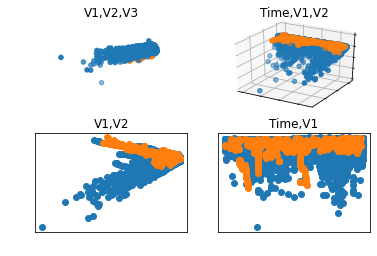

In [11]:
legit_x    =legit.select("V1").toPandas()
legit_y    =legit.select("V2").toPandas()
legit_z    =legit.select("V3").toPandas()
legit_time =legit.select("Time").toPandas()

fraud_x    =fraud.select("V1").toPandas()
fraud_y    =fraud.select("V2").toPandas()
fraud_z    =fraud.select("V3").toPandas()
fraud_time =fraud.select("Time").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.axis('off')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V1,V2,V3")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, fraud_z)

ax = fig.add_subplot(2,2,3)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V1,V2")
ax.scatter(legit_x, legit_y)
ax.scatter(fraud_x, fraud_y)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("Time,V1,V2")
ax.scatter(legit_time, legit_x, legit_y)
ax.scatter(fraud_time, fraud_x, fraud_y)

ax = fig.add_subplot(2,2,4)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("Time,V1")
ax.scatter(legit_time, legit_x)
ax.scatter(fraud_time, fraud_x)

plt.show()

Vediamo come le transazioni fraudolente siano all'interno dello spazio delle features contigue e abbastanza compatte. Inoltre il tempo è una feature che potrebbe risultare utile poiché le due classi sembrano avere maggiore variazione di V1 in corrispondenza di orari diversi.

## Classification

Visto che le due classi sono fortemente sbilanciate, il classificatore verrebbe principalmente addestrato su campioni appartenenti alla classe delle transazioni legittime, introducendo un bias indesiderato: tutte le transazioni verrebbero classificate come legittime. 
Per questo motivo utilizziamo delle tecniche per mitigare il problema.

In [16]:
# Definiamo una funzione per stampare l'area sotto la curva precision-recall e 
# la matrice di confusione per il training set.
from pyspark.ml.tuning import CrossValidator

def evaluate_model(cvModel, train, test, callable=True):
  evaluator = cvModel.getEvaluator()
  predictions = cvModel.transform(test)
  performance = cvModel.transform(train)
  summary = cvModel.bestModel.stages[2].summary() \
            if callable else cvModel.bestModel.stages[2].summary

  auprc = evaluator.evaluate(performance)
  print(f"Area Under PR Curve (train): {(100*auprc):05.2f}%")

  plt.figure(figsize=(5,5))
  plt.plot([0, 1], [0, 1], 'r--')
  plt.plot(summary.roc.select('FPR').collect(),
          summary.roc.select('TPR').collect())
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title("Precision-Recall curve")
  plt.show()

  print("Test set results:")
  auprc = evaluator.evaluate(predictions)
  print(f"Area Under PR Curve:  {(100*auprc):05.2f}%")

  predictions.createOrReplaceTempView('predictions')
  tp = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 1 AND
                    predictions.prediction == 1.0 """).collect()[0].c
  print(f"True positives:       {tp}")
  fp = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 0 AND
                    predictions.prediction == 1.0 """).collect()[0].c
  print(f"False positives:      {fp}")
  tn = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 0 AND
                    predictions.prediction == 0.0 """).collect()[0].c
  print(f"True negatives:       {tn}")
  fn = spark.sql("""SELECT COUNT(*) as c
                    FROM predictions
                    WHERE predictions.Class == 1 AND
                    predictions.prediction == 0.0 """).collect()[0].c
  print(f"False negatives:      {fn}")

  sn.heatmap([[tp, fp],[fn,tn]], annot=True, fmt='.3g', cbar=False)\
   .set_title("Confusion matrix");

  precision = (tp)/(tp+fp)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  recall = (tp)/(tp+fn)
  print(f"Precision:            {precision:1.3f}")
  print(f"Accuracy:             {accuracy:1.3f}")
  print(f"Recall:               {recall:1.3f}")
  print(f"F1:                   {(2*precision*recall)/(precision+recall):1.3f}")
  

In [17]:
# L'evaluator sarà lo stesso per tutti i modelli
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("Class")\
                                           .setMetricName("areaUnderPR")

In [19]:
# Necessary imports for all methods

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import StringIndexer

# The two classifiers
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier 

### Undersampling

Nel training set sottocampioniamo gli elementi appartenenti alla classe dominante per non introdurre bias sulla frequenza relativa delle classi.

In [12]:
# Per ottenere train e test set tramite undersampling

def undersample_split(fraud, legit):
  train_f, test_f = fraud.randomSplit([0.8, 0.2])
  train_l, test_l = legit.randomSplit([0.8, 0.2])
  train_l = train_l.sample(False, 1.0*fraud.count()/legit.count()) \
      .limit (train_f.count())
  
  train       = train_f.union(train_l)
  test        = test_f.union(test_l)
  return (train, test)

##### Support vector machine 

Come primo approccio proviamo ad utilizzare come classificatore una support vector machine lineare, inoltre sottocampioniamo le transazioni legittime per non avere un dataset sbilanciato.

In [16]:

train, test = undersample_split(fraud, legit)


labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
linearSVC = LinearSVC().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)

pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                linearSVC,\
                                labelConverter])

In [17]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(linearSVC.regParam, [0.1, 0.2, 0.5])\
                              .addGrid(linearSVC.maxIter, [20,50,100,200])\
                              .build()

In [18]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

In [ ]:
cvModel_svm_us = cv.fit(train)

evaluate_model(cvModel_svm_us, train, test)

#### Random forest 

Confrontiamo il risultato precedente con una random forest, addestrata con gli stessi dati.

In [ ]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
randomForest = RandomForestClassifier().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)
pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                randomForest,\
                                labelConverter])


In [ ]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(randomForest.maxBins,[25, 28, 31])\
                              .addGrid(randomForest.maxDepth,[4,6,8])\
                              .addGrid(randomForest.impurity,["entropy","gini"])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

cvModel_random_forest_us = cv.fit(train)

In [ ]:

evaluate_model(cvModel_random_forest_us, train, test, callable=False)

### Oversampling

Facendo undersampling non prendiamo in considerazione la maggior parte delle informazioni disponibili sulla classe dominante, portando a bassa capacità della rete di generalizzare, ricorriamo quindi ad oversampling.
Nel training set presentiamo più volte gli elementi appartenenti alla classe meno frequente per non introdurre bias sulla frequenza relativa delle classi.

Il test set viene estratto prima della duplicazione dei campioni per evitare di testare il classificatore sugli stessi dati su cui è stato testato.

In [22]:
# Per ottenere train e test set tramite undersampling
import math
def oversample_split(fraud, legit):
  train_f, test_f = fraud.randomSplit([0.8, 0.2])
  train_l, test_l = legit.randomSplit([0.8, 0.2])

  a = range(math.ceil(train_l.count()/train_f.count()))
    # duplicate the minority rows
  oversampled_train_f = train_f.withColumn("dummy", explode(array([lit(x) for x in a])))\
    .drop('dummy')
  # The train test is balanced with 50/50 frauds and legit transactions
  # to avoid bias towards legit transactions
  train       = oversampled_train_f.union(train_l)
  # The test set has the same distribution of the original dataset
  test        = test_f.union(test_l)
  return (train, test)

#### Random forest 

Confrontiamo il risultato precedente con una random forest, addestrata con gli stessi dati.

In [23]:
labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
randomForest = RandomForestClassifier().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)
pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                randomForest,\
                                labelConverter])


In [24]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(randomForest.maxBins,[25, 28, 31])\
                              .addGrid(randomForest.maxDepth,[4,6,8])\
                              .addGrid(randomForest.impurity,["entropy","gini"])\
                              .build()

In [25]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

cvModel_random_forest_os = cv.fit(train)

Area Under PR Curve (train): 99.96%


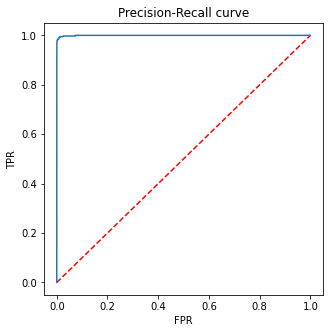

Test set results:
Area Under PR Curve:  80.10%
True positives:       78
False positives:      54
True negatives:       57289
False negatives:      16
Precision:            0.591
Accuracy:             0.999
Recall:               0.830
F1:                   0.690


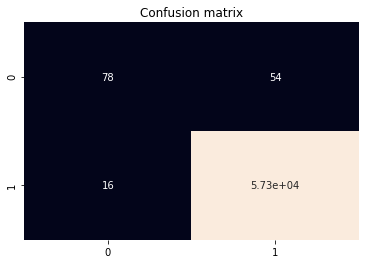

In [26]:

evaluate_model(cvModel_random_forest_os, train, test, callable=False)

La random forest ha prestazioni superiori rispetto alla SVM.

#### Support vector machine 

Come primo approccio proviamo ad utilizzare come classificatore una support vector machine lineare, inoltre sottocampioniamo le transazioni legittime per non avere un dataset sbilanciato.

In [27]:
train, test = oversample_split(fraud, legit)


labelIndexer = StringIndexer(inputCol='Class',outputCol='Class_index').fit(train)

assembler = VectorAssembler().setInputCols(train.schema.names[0:-1])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
linearSVC = LinearSVC().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)

pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                linearSVC,\
                                labelConverter])

In [28]:
# Costruiamo l'algoritmo di addestramento, come una 10-fold Cross-validation che si addestra su una 
# griglia di iperparametri:
# -- l'indice di Gini, e l'entropia per controlla la purezza dei nodi foglia
# -- il numero di bin cioè di categorie da generare per ogni feature categorica
# -- la profondità massima dell'albero

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(linearSVC.regParam, [0.1, 0.2, 0.5])\
                              .addGrid(linearSVC.maxIter, [20,50,100,200])\
                              .build()

In [29]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

In [ ]:
cvModel_svm_os = cv.fit(train)

evaluate_model(cvModel_svm_os, train, test)

### Selezione delle feature

I modelli precedenti si comportano abbastanza bene, soprattutto la random forest. L'addestramento sta però avvenendo su un sottoinsieme molto piccolo dei dati sulle transazioni legittime, potremmo quindi non catturare delle caratteristiche importanti dei dati. Risulta quindi opportuno provare un oversampling. 

L'addestramento con una porzione così grande del dataset con vettori di 30 feature però è una operazione molto pesante, ed è anche possibile che l'elevata dimensionalità riduca il potere di discriminazione dei modelli (curse of dimensionality). Effettuiamo quindi delle operazioni di estrazione delle features.

#### Sfruttamento dei modelli addestrati precedentemente

Dai modelli appena addestrati è possibile ottenere informazioni riguardo l'importanza delle varie features.


##### **SVM**

Visto che le feature provengono da una PCA sono linearmente non correlate tra loro, i pesi appresi dalla SVM possono quindi fornire informazione su quali feature sono più rilevanti per la separazione delle due classi.

In [ ]:
cvModel_svm.bestModel.stages[2].coefficients

Scaliamo il valore assoluto dei coefficienti per avere somma unitaria e li riportiamo nella tabella seguente 

Feature | Weight
-|-
 V14 | 0.1124 
 V28 | 0.1101 
 V2 | 0.0814 
 V4 | 0.0803 
 V20 | 0.0796 
 V11 | 0.0505 
 Amount | 0.0503 
 V6 | 0.0492 
 V12 | 0.0395 
 V9 | 0.0338 
 V10 | 0.0335 
 V7 | 0.0330 
 V23 | 0.0318 
 V27 | 0.0308 
 V5 | 0.0260 
 V1 | 0.0219 
 V3 | 0.0193 
 V16 | 0.0185 
 V21 | 0.0182 
 V17 | 0.0161 
 V19 | 0.0138 
 V18 | 0.0122 
 V25 | 0.0104 
 V24 | 0.0057 
 V22 | 0.0053 
 V26 | 0.0048 
 V8 | 0.0040 
 V13 | 0.0031 
 V15 | 0.0016 
 Time | 0.0014 


Le prime sei feature hanno più del 50% dell'importanza, e scartando le ultime 12 non si perde più del 10%.


In [ ]:
legit_x    =legit.select("V21").toPandas()
legit_y    =legit.select("V14").toPandas()
legit_z    =legit.select("V2").toPandas()

fraud_x    =fraud.select("V21").toPandas()
fraud_y    =fraud.select("V14").toPandas()
fraud_z    =fraud.select("V2").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V21,V14,V2")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, fraud_z)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V21,V2")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, fraud_z)

ax = fig.add_subplot(2,2,3,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V21,V14,V2 (bottom view)")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, -fraud_z)

ax = fig.add_subplot(2,2,4,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V21,V2 (bottom view)")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, -fraud_z)

plt.show()

Osserviamo che considerando le sole tre features con i pesi maggiori è già possibile distinguere abbastanza nitidamente le due classi, meglio di quanto visto usando come features V1, V2, V3, e il Tempo, che effettivamente risultano essere abbastanza in basso nella lista ed eccezione di V2.

###### _Performance su un numero di feature ridotto:_

Proviamo ad addestrare la SVM utilizzando solamente le 7 feature associate a pesi maggiori.

In [ ]:
train, test = undersample_split(fraud, legit)


assembler = VectorAssembler().setInputCols(["V21", "V14", "V2", "V4",
                                            "V11", "V23", "V10" ])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
linearSVC = LinearSVC().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)

pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                linearSVC,\
                                labelConverter])

# Generiamo la griglia
paramGrid = ParamGridBuilder().addGrid(linearSVC.regParam, [0.1, 0.2, 0.5])\
                              .addGrid(linearSVC.maxIter, [20,50,100,200])\
                              .build()



In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)

cvModel_svm_reduced = cv.fit(train)

In [ ]:
evaluate_model(cvModel_svm_reduced, train, test)

La performance del classificatore è leggermente aumentata rimuovendo le feature meno importanti.

##### **Random Forest**

Ripetiamo un procedimento simile sulla random forest, che precedentemente dava migliori risultati nella classificazione.

In [ ]:
cvModel_random_forest.bestModel.stages[2].featureImportances

Per comodità di visione si riportano i dati in output al comando precedente anche in formato tabellare.

Feature | Importance
-|-
 V14 |  0.191
 V17 |  0.1691
 V10 |  0.14
 V12 |  0.1082
 V4 |  0.1041
 V11 |  0.0341
 V7 |  0.0309
 V16 |  0.0267
 V3 |  0.0166
 Amount |  0.0159
 V20 |  0.0134
 V19 |  0.0131
 V21 |  0.0128
 V8 |  0.0126
 V5 |  0.0121
 V2 |  0.0106
 V9 |  0.0096
 V13 |  0.0084
 V22 |  0.0076
 V24 |  0.0074
 V27 |  0.0071
 V18 |  0.0069
 V1 |  0.0069
 V15 |  0.0065
 Time |  0.0059
 V25 |  0.0057
 V6 |  0.0052
 V23 |  0.0052
 V28 |  0.0038
 V26 |  0.0025

Le prime tre features da sole hanno il 50% dell'importanza, e per arrivare al 90% se ne possono scartare metà.

In [ ]:
legit_x    =legit.select("V14").toPandas()
legit_y    =legit.select("V17").toPandas()
legit_z    =legit.select("V10").toPandas()

fraud_x    =fraud.select("V14").toPandas()
fraud_y    =fraud.select("V17").toPandas()
fraud_z    =fraud.select("V10").toPandas()

fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V17,V10")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, fraud_z)

ax = fig.add_subplot(2,2,2,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V14,V10")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, fraud_z)

ax = fig.add_subplot(2,2,3,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V14,V17,V10 (bottom view)")
ax.scatter(legit_x, legit_y, legit_z)
ax.scatter(fraud_x, fraud_y, -fraud_z)

ax = fig.add_subplot(2,2,4,projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title("V17,V14,V10 (bottom view)")
ax.scatter(legit_y, legit_x, legit_z)
ax.scatter(fraud_y, fraud_x, -fraud_z)

plt.show()

Ad una ispezione visiva sembra evidente come, utilizzando le prime tre feature, le due classi risultino meglio separate di quanto non succedesse per la SVM.

###### _Performance su numero di feature ridotto_:
Proviamo ad addestrare la random forest utilizzando soltanto le prime tre feature

In [ ]:
assembler = VectorAssembler().setInputCols(["V14","V17","V10" ])\
  .setOutputCol("features")
scaler = MinMaxScaler().setMin(0).setMax(1).setInputCol("features") \
  .setOutputCol("scaled_features")
randomForest = RandomForestClassifier().setFeaturesCol("scaled_features") \
  .setLabelCol("Class")
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel')\
  .setLabels(labelIndexer.labels)
pipeline = Pipeline().setStages([assembler, \
                                scaler, \
                                randomForest,\
                                labelConverter])

paramGrid = ParamGridBuilder().addGrid(randomForest.maxBins,[25, 28, 31])\
                              .addGrid(randomForest.maxDepth,[4,6,8])\
                              .addGrid(randomForest.impurity,["entropy","gini"])\
                              .build()

In [ ]:
cv = CrossValidator().setEstimator(pipeline)\
                     .setEvaluator(evaluator)\
                     .setEstimatorParamMaps(paramGrid)\
                     .setNumFolds(10)
                     
cvModel_random_forest_reduced = cv.fit(train)

In [ ]:
evaluate_model(cvModel_random_forest_reduced, train, test, callable=False)

Vediamo come usare soltanto le prime tre feature permette di ottenere risultati estremamente vicini a quelli ottenuti usando tutte e trenta le feature.